In [1]:
import rebound as rb
import celmech as cm
from amd_equipartition_utils import generate_simulations, run_secular_system_simulation

from matplotlib import pyplot as plt

import numpy as np

from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp

# Set up simulations

In [11]:
mpl = 1e-5
Npl = 3
masses = 1e-5 * np.ones(Npl)
delta = 0.5
a= (1+delta)**np.arange(Npl)
sims = generate_simulations(masses,a,2,fcrit=2)

Set up a default secular simulation class to integrate using the symplectic implicit GL6 Runge-Kutta method.

In [2]:
sec_sim = cm.secular.SecularSystemSimulation.from_Simulation(
    sims[0],
    dtFraction=0.05,
    method='RK',
    rk_kwargs={'rk_method':'GL6'}
)
# Set absolute tolerance based on total AMD 
sec_sim._integrator.atol = 1e-10 * np.sqrt(sec_sim.calculate_AMD())

Tfin = 2e7*np.pi # 1Gyr
Nout = 512
times = np.linspace(0,Tfin,Nout)
results = run_secular_system_simulation(sec_sim,times)

Use `scipy.solve_ivp` to run an integration using the BDF method. The flow function of the secular simulation is input to the initial value problem solver. 

This provides a template for different integrators/settings/etc combinations.

In [8]:
fn = lambda t,y: sec_sim._integrator.f(y)
ivp_soln = solve_ivp(
    fn,
    (0,results['times'][-1]),
    y0 = results['qp'][0],
    t_eval = results['times'],
    method='BDF',
    atol = sec_sim._integrator.atol,
    rtol = 1e-10
)

# Plots

Plot fration energy errors. `sovle_ivp` genrally has a long-term trend while the symplectic `GL6` method usually only exhibits oscillating energy errors.

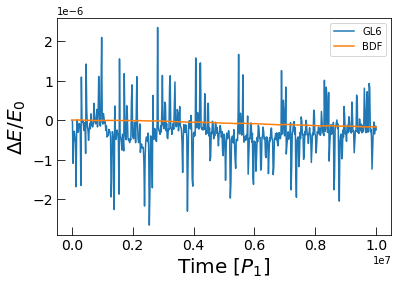

In [9]:
E_BDF = np.array([sec_sim._integrator.calculate_energy(x) for x in ivp_soln.y.T])
E_GL6 = results['energy']

plt.plot(ivp_soln.t/(2*np.pi),E_GL6/E_GL6[0]-1,label='GL6')
plt.plot(ivp_soln.t/(2*np.pi),E_BDF/E_BDF[0]-1,label='BDF')
plt.legend()
plt.ylabel("$\Delta E / E_0$",fontsize=20)
plt.xlabel("Time [$P_1$]",fontsize=20)
plt.tick_params(labelsize=14,direction='in',size=8)

Eccentricty variable evolutions

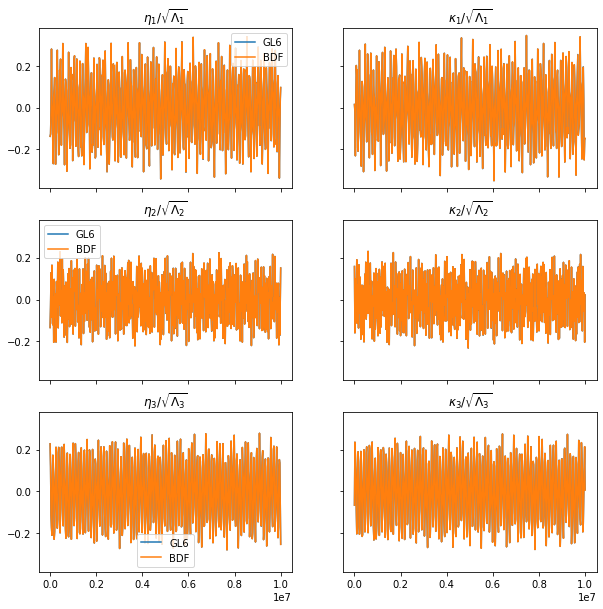

In [10]:
fig,ax = plt.subplots(Npl,2,figsize = (10,10),sharex=True,sharey=True)
for i in range(Npl):
    Lmbda = sec_sim.Lambda0s[i+1]
    ax[i,0].plot(results['times']/(2*np.pi),results['qp'][:,i]/np.sqrt(Lmbda),label='GL6')
    ax[i,0].plot(ivp_soln.t/(2*np.pi),ivp_soln.y[i]/np.sqrt(Lmbda),label='BDF')
    ax[i,1].plot(results['times']/(2*np.pi),results['qp'][:,2*Npl+i]/np.sqrt(Lmbda))
    ax[i,1].plot(ivp_soln.t/(2*np.pi),ivp_soln.y[2*Npl+i]/np.sqrt(Lmbda))
    ax[i,0].legend()
    ax[i,0].set_title("$\eta_{0}/\sqrt{{\Lambda_{0}}}$".format(i+1))
    ax[i,1].set_title("$\kappa_{0}/\sqrt{{\Lambda_{0}}}$".format(i+1))